# Final project: Finding the suspect

<a href="https://en.wikipedia.org/wiki/Facial_composite.">Facial composits</a> are widely used in forensics to generate images of suspects. Since victim or witness usually isn't good at drawing, computer-aided generation is applied to reconstruct the face attacker. One of the most commonly used techniques are evolutionary systems that compose the final face from many predefined parts.

In this project we will try to implement an app for crating facial composite that will be able to construct desired faces without explicitly providing databases of templates. We will apply Variational Autoencoders and Gaussian processes for this task.

Final project is developed in a way that you can apply learned techniques to real project yourself. We will include main guidelines and hints, but great part of the project will need your creativity and experience from previous assignments.

### Installation

We will need ```tensorflow```, ```keras```, ```GPy```, ```GPyOpt```, ```h5py``` libraries for this assignment.

In [0]:
# Install necessary modules on google colab
!pip install gpy
!pip install GPyOpt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import GPy
import GPyOpt
import keras
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, Activation, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Deconv2D
from keras.losses import MSE
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import utils_mod
import os
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Mount drive to access CelebA_VAE_small_8.h5
from google.colab import drive
drive.mount('/content/drive')

In [0]:
os.chdir("/content/drive/My Drive/Colab Notebooks/")
!ls

### Grading
As some of the final project tasks can be graded only visually, final assignment is graded using peer-review procedure. You will be asked to upload your Jupyter notebook on the web and attach link to it in the submission form. Detailed submission instructions and grading criterions are written in the end of this notebook.

## Model description
We will first train variational autoencoder on face images to compress them to low dimension. One important feature of VAE is that constructed latent space is in some sence continous. That means, that we can safely move along the space and any point along our path will be reconstructed into a valid face.

Using this continuous latent space we can use bayesian optimization to maximise some similarity function between person's face in victim/witness's memory and a face reconstructed from current point of latent space. Bayesian optimization is an appropriate choice here, since people start to forget detales about the attacker after they were shown many similar photos. Because of this, we want to reconstruct the photo with the smallest possible number of trials.

## Generating faces

For this task you will need to use some database of face images. There are multiple datasets available on the web that you can use: for example, <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">CelebA</a> or <a href="http://vis-www.cs.umass.edu/lfw/">Labeled Faces in the Wild</a>. We used Alligned & Cropped version of CelebA that you can find <a href="https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADSNUu0bseoCKuxuI5ZeTl1a/Img?dl=0&preview=img_align_celeba.zip">here</a> to pretrain VAE model for you. See optional part of final project if you whish to train VAE on your own.

<b>Task 1:</b> Train VAE on faces dataset and draw some samples from it. (You can use code from previous assignmnets. You may also want to use convolutional encoders and decoders as well as tuning hyperparameters)

In [0]:
sess = tf.InteractiveSession()
K.set_session(sess)

In [0]:
latent_size = 8

In [7]:
vae, encoder, decoder = utils_mod.create_vae(batch_size=128, latent=latent_size)
sess.run(tf.global_variables_initializer())
vae.load_weights("/content/drive/My Drive/Colab Notebooks/CelebA_VAE_small_8.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
vae

In [0]:
K.set_learning_phase(False)

In [0]:
latent_placeholder = tf.placeholder(tf.float32, (1, latent_size))
decode = decoder(latent_placeholder)

In [11]:
latent_placeholder
# -> latent_size specified at 8 (see above), name of placeholder 'Placeholder_41:0'

<tf.Tensor 'Placeholder_41:0' shape=(1, 8) dtype=float32>

In [24]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4800      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         819200    
__________

In [23]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              73728     
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 512)         6553600   
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
activation_5 (Activation)    (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 256)       3276800   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 256)       1024      
__________

#### GRADED 1 (3 points): Draw 25 samples from trained VAE model
As first part of assignment, you need to become familiar with trained model. For all tasks you will only need a decoder to reconstruct samples froma a latent space.

To decode latent variable, you need to run ```decode``` operation defined above with random samples from standard normal distribution.

In [12]:
# What shape has the decoder?
decode

<tf.Tensor 'sequential_2_1/conv2d_transpose_4/BiasAdd:0' shape=(1, 64, 64, 3) dtype=float32>

In [13]:
# decode operation needs 8d input (latent_size = 8) for its placeholder
# define by draws from standard normal distribution, e.g. one case to replace placeholder:
np.random.randn(1, 8)

array([[ 0.92642662,  0.23159894,  0.8473865 ,  0.01562114, -0.53726969,
        -1.70654985, -1.2015971 ,  1.92903191]])

In [14]:
# shape has to be reshaped to original dimensionality of image data
print(sess.run(decode, feed_dict={'Placeholder_41:0': np.random.randn(1, 8)}).shape)
print(sess.run(decode, feed_dict={'Placeholder_41:0': np.random.randn(1, 8)}).reshape((64,64,3)).shape)

(1, 64, 64, 3)
(64, 64, 3)


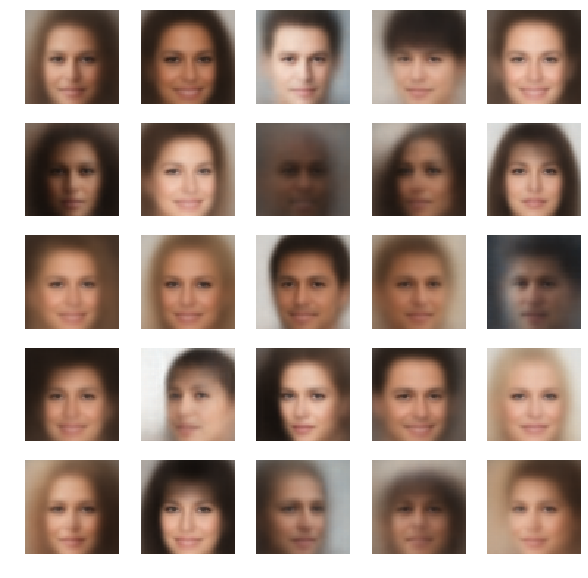

In [15]:
### TODO: Draw 25 samples from VAE here
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    # run the defined decoder with 8d draw from standard normal for placeholder
    # reshape 
    image = sess.run(decode, feed_dict={'Placeholder_41:0': np.random.randn(1, 8)}).reshape((64,64,3))
    plt.imshow(np.clip(image, 0, 1))
    plt.axis('off')

## Search procedure

Now that we have a way to reconstruct images, we need to set up an optimization procedure to find a person that will be the most similar to the one we are thinking about. To do so, we need to set up some scoring utility. Imagine that you want to generate an image of Brad Pitt. You start with a small number of random samples, say 5, and rank them according their similarity to your vision of Brad Pitt: 1 for the worst, 5 for the best. You then rate image by image using GPyOpt that works in a latent space of VAE. For the new image you need to somehow assign a real number that will show how good this image is. The simple idea is to ask a user to compare a new image with previous images (along with their scores). User then enters score to a current image.

The proposed scoring has a lot of drawbacks, and you may feel free to come up with new ones: e.g. showing user 9 different images and asking a user which image looks the "best".

Note that the goal of this task is for you to implement a new algorithm by yourself. You may try different techniques for your task and select one that works the best.

<b>Task 2:</b> Implement person search using Bayesian optimization. (You can use code from the assignment on Gaussian Processes)

Note: try varying ```acquisition_type``` and ```acquisition_par``` parameters.

In [0]:
class FacialComposit:
    # init of self also needs an indication of how many images to use
    def __init__(self, decoder, latent_size):
      # generalized setup of the decoder from above (e.g. latent_size)
        self.latent_size = latent_size
        self.latent_placeholder = tf.placeholder(tf.float32, (1, latent_size))
        self.decode = decoder(self.latent_placeholder)
        self.samples = None
        self.images = None
        self.rating = None

    def _get_image(self, latent):
      # generalized runtime of the image generation process by the decoder
        img = sess.run(self.decode, 
                       feed_dict={self.latent_placeholder: latent[None, :]})[0]
        img = np.clip(img, 0, 1)
        return img

    @staticmethod
    def _show_images(images, titles):
      # simple visualization of the results of _get_image
        assert len(images) == len(titles)
        clear_output()
        plt.figure(figsize=(3*len(images), 3))
        n = len(titles)
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(images[i])
            plt.title(str(titles[i]))
            plt.axis('off')
        plt.show()

    @staticmethod
    def _draw_border(image, w=2):
        bordred_image = image.copy()
        bordred_image[:, :w] = [1, 0, 0]
        bordred_image[:, -w:] = [1, 0, 0]
        bordred_image[:w, :] = [1, 0, 0]
        bordred_image[-w:, :] = [1, 0, 0]
        return bordred_image

    def query_initial(self, n_start = 10, select_top = 3):
        '''
        Creates initial points for Bayesian optimization
        Generate *n_start* random images and asks user to rank them.
        Gives maximum score to the best image and minimum to the worst.
        :param n_start: number of images to rank initialy.
        :param select_top: number of images to keep
        '''
        # Two step approach: First draw to tmp, after user feedback get to self.[...] written
        
        # input for image generation is sequence form standard normal for n_start initial images of dimension to latent_size in self.
        samples = np.random.randn(n_start, self.latent_size)
        # run the tensorflow session image generation defined in self._get_image for every row in drawn sample from standard normal
        images = np.array([self._get_image(row) for row in samples])
        
        # plot the just generated images via udf _show_images from self., titles equal to n_start range
        self._show_images(images, range(n_start))
        
        # Use input() function to ask user for rating of shown pictures, split by ',' and get to int ratings
        in_user = [int(i) for i in input("You are seeing {n} pictures that could be a match for the suspicious person you are having in mind.\nWould you please be so kind and rank the showed persons for me on a scale ranging from 0 (:no similarity at all) and 100 (highest similarity)?\nPlease use only integer numbers and separate them by commas (e.g. 1, 35, 99, ..., 5)".format(n = n_start)).split(',')]
        
        # sort now the input index by lowest rating to highest to get them ordered into self. afterwards
        idx_user = np.argsort(in_user)
        
        # set ordered sample data, resulting image and rating to pool for only best select_top matches
        # has not to be combined with self.xxx, as initial is None
        self.samples = np.array(samples)[idx_user][-select_top:]
        self.images = np.array(images)[idx_user][-select_top:]
        self.rating = np.array(in_user)[idx_user][-select_top:]
                
        # Check that tensor sizes are correct
        np.testing.assert_equal(self.rating.shape, [select_top])
        np.testing.assert_equal(self.images.shape, [select_top, 64, 64, 3])
        np.testing.assert_equal(self.samples.shape, [select_top, self.latent_size])

    def evaluate(self, candidate):
        '''
        Queries candidate vs known image set.
        Adds candidate into images pool.
        :param candidate: latent vector of size 1xlatent_size
        '''
        
        ## Show user an image and ask to assign score to it.
        ## You may want to show some images to user along with their scores
        ## You should also save candidate, corresponding image and rating
        
        # get the new candidate image, which is of shape (1, 8) -> send to self._get_image to convert to image
        candidate_image = self._get_image(candidate[0]).reshape((1, 64, 64, 3))
        # how many images stored already in pool? at which position + 1 might this candidate be placed?
        initial_size = len(self.images)
        
        # images to show? candidate necessity, also some others as reference: a) best so far, b) worst so far, c) one random in beetween
        # image indizes can be achieved by using argsort on corresponding ratings
        sorted_ranking_idx = np.argsort(self.rating)[::-1] # ranking, as from second round onwards order otherwise not guaranteed
        best = sorted_ranking_idx[-1]; worst = sorted_ranking_idx[0]; rnd_choice = np.random.choice(sorted_ranking_idx[1:-1], 1, replace = False)
        
        idx_image_pool = np.concatenate((np.array([best, worst]), rnd_choice), axis = None) # index of choices
        
        # combine candidate with other images
        images_pool = np.append(candidate_image, self.images[idx_image_pool], axis = 0)
        ratings_pool = self.rating[idx_image_pool]
        
        # combine candidate and reference images 
        images_to_display = np.append(candidate_image, images_pool, axis = 0)

        # plot images with their rating and display new candidate to be rated according
        # self._show_images can get list of titles to display rating, first one is the candidate
        titles = ["This is the new candidate displayed"] + ["Rating for this image is: " + str(ratings_pool[i]) for i in range(3)] # 3: best, worst, one random
        self._show_images(images_pool, titles)
        
        candidate_rating = int(input("Could you please rate the new displayed person on a scale from 0 (:no similarity at all) and 100 (highest similarity)?\nThe existing ratings for different person help you as a reference, please use only integer numbers (e.g. 1, 2, ..., 10).\n"))
        
        # candidate image, data, and rating to general pool
        self.images = np.append(self.images, candidate_image, axis=0)
        self.samples = np.append(self.samples, candidate, axis=0)
        self.rating = np.append(self.rating, np.array([candidate_rating]))
        
        assert len(self.images) == initial_size + 1
        assert len(self.rating) == initial_size + 1
        assert len(self.samples) == initial_size + 1
        return candidate_rating

    def optimize(self, n_iter=10, w=2, acquisition_type='MPI', acquisition_par=0.3):
        if self.samples is None:
            self.query_initial()

        bounds = [{'name': 'z_{0:03d}'.format(i),
                   'type': 'continuous',
                   'domain': (-w, w)} 
                  for i in range(self.latent_size)]
        optimizer = GPyOpt.methods.BayesianOptimization(f=self.evaluate, domain=bounds,
                                                        acquisition_type = acquisition_type,
                                                        acquisition_par = acquisition_par,
                                                        exact_eval=False, # Since we are not sure
                                                        model_type='GP',
                                                        jitter = -2, # -> tend to exploration (+), or exploitation (-)
                                                        X=self.samples,
                                                        Y=self.rating[:, None],
                                                        maximize=True)
        optimizer.run_optimization(max_iter=n_iter, eps=-1)

    def get_best(self):
        index_best = np.argmax(self.rating)
        return self.images[index_best]

    def draw_best(self, title=''):
        index_best = np.argmax(self.rating)
        image = self.images[index_best]
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()

#### GRADED 2 (3 points):
Describe your approach below: How do you assign score to a new image? How do you select reference images to help user assign a new score? What are the limitations of your approach?

**Initial idea:** The user gets initial a random set of images presented to get some starting guess. User is asked to rate every picture according to the given description on a scale from 0 to 100. This allows enough variation for ratings, the best n (3) images go to the self. storage for further comparison/improvement.

**Selecting new candidata rating:** the initial draw optimization goes step by step always having one candidate to benchmark against existing images and their ratings. The reference here is: the worst and best one so far, plus an additional random draw from the pool. This allows the user to reference the candidate against the lower and upper bound he has defined so far.

**Drawback**: User relative ratings might shift during the run. What he initially regards as best so far, might turn out later not to be that optimal, but already the scale is fixed by him/her - true rating values might not be possible anymore with the used range of the scale so far. 

Simple comparison (e.g. better than before, worse than before) might overcome that specific problem, but on the other hand don't allow for more differentiated ratings. 

Also, distance of ratings is not really taking into account with this approach. Maybe used to make third picture more relative to best/worst so far. But: Idea of random draw should give a chance for uniform probability of additional comparison on all end of the scale.


## Testing your algorithm

In the these sections we will apply implemented app to search of different people. Each task will ask you to generate images that will have some property like "dark hair" or "moustache". You will need to run your search algorithm and provide best found image.

#### Task 3.1: Finding person with darkest hair (3 points)

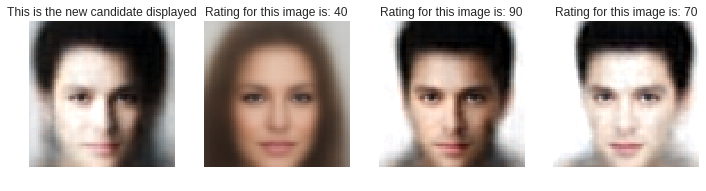

Could you please rate the new displayed person on a scale from 0 (:no similarity at all) and 100 (highest similarity)?
The existing ratings for different person help you as a reference, please use only integer numbers (e.g. 1, 2, ..., 10).
80


In [70]:
composit = FacialComposit(decoder, 8)
composit.optimize()

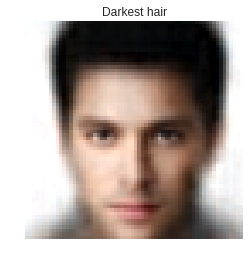

In [71]:
composit.draw_best('Darkest hair')

#### Task 3.2. Finding person with the widest smile (3 points)

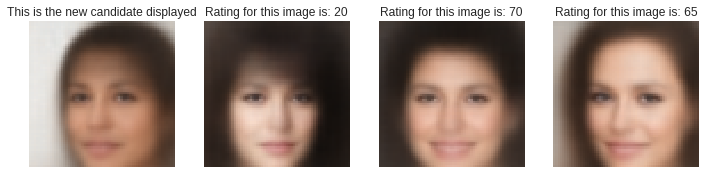

Could you please rate the new displayed person on a scale from 0 (:no similarity at all) and 100 (highest similarity)?
The existing ratings for different person help you as a reference, please use only integer numbers (e.g. 1, 2, ..., 10).
50


In [96]:
composit = FacialComposit(decoder, 8)
composit.optimize()

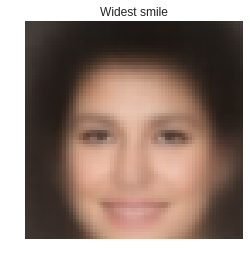

In [97]:
composit.draw_best('Widest smile')

#### Task 3.3. Finding Daniil Polykovskiy or Alexander Novikov — lecturers of this course (3 points) 

Note: this task highly depends on a quality of VAE and search algorithm. You may need to restart your search algorithm a few times and start with larget initial set.

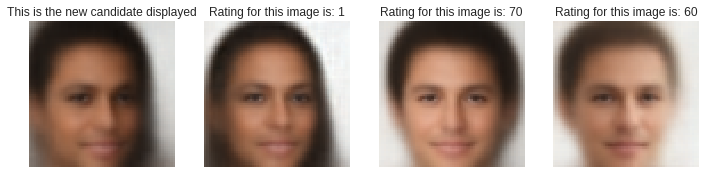

Could you please rate the new displayed person on a scale from 0 (:no similarity at all) and 100 (highest similarity)?
The existing ratings for different person help you as a reference, please use only integer numbers (e.g. 1, 2, ..., 10).
45


In [118]:
composit = FacialComposit(decoder, 8)
composit.optimize()

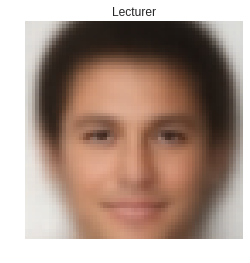

In [119]:
# Daniil Polykovskiy -> Yes I know: No glasses, no beard, slightly shorter hair and he is smiling more than usual...
# ...but there is some similarity!... 
composit.draw_best('Lecturer')

#### <small>Don't forget to post resulting image of lecturers on the forum ;)</small>

#### Task 3.4. Finding specific person (optional, but very cool)

Now that you have a good sence of what your algorithm can do, here is an optional assignment for you. Think of a famous person and take look at his/her picture for a minute. Then use your app to create an image of the person you thought of. You can post it in the forum <a href="https://www.coursera.org/learn/bayesian-methods-in-machine-learning/discussions/forums/SE06u3rLEeeh0gq4yYKIVA">Final project: guess who!</a>


In [0]:
### Your code here

### Submission
You should submit an HTML version of your work. To convert your notebook to HTML, press file $\rightarrow$ download as $\rightarrow$  HTML (.html). Make sure that resulting html file can be opened when copied to a separate folder (that all of the images are present). You should attach only your html file to the peer review console.

### Grading criterions

#### Task 1 (3 points) [samples from VAE]
* 0 points: No results were provided here or provided images were not generated by VAE
* 1 point: Provided images poorly resemble faces
* 2 points: Provided images look like faces, maybe with some artifacts, but all look the same
* 3 points: Provided images look like faces, maybe with some artifacts, and look different

#### Task 2 (3 points) [training procedure]
* 0 points: No result was provided
* 1 point: Some algorithm was proposed, but it does not use Bayesian optimization
* 2 points: Algorithm was proposed, but there were no details on some important aspects: how to assign a score to a new image / how to you select a new image / what are the limitations of the approach
* 3 points: Algorithm was proposed, all questions in the task were answered

#### Tasks 3.1-3.3 (3 points each) [search for person]
* 0 points: Nothing was provided
* 1 point: Resulting image was provided, but some of the required images (evolution & nearest image) are not provided
* 2 points: All images are provided, but resulting image does not have requested property
* 3 points: All images are provided, resulting image has required features (long hair / wide smile / looks like lecturer)

## Passing grade is 60% (9 points)